<img align="right" width="400" src="https://www.fhnw.ch/de/++theme++web16theme/assets/media/img/fachhochschule-nordwestschweiz-fhnw-logo.svg" alt="FHNW Logo">


# RNN Text Classifier

by Fabian Märki

## Summary
The aim of this notebook is to program a RNN text classifier. Additionally, it sets the stage for a later hyperparameter tuning also allowing for model design optimization.

<a href="https://colab.research.google.com/github/markif/2021_HS_DAS_NLP_Notebooks/blob/master/06_a_RNN_Text_Classifier.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [3]:
!pip install 'fhnw-nlp-utils>=0.1.3'
!pip install pyarrow fastparquet


from fhnw.nlp.utils.storage import load_dataframe
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.colab import runs_on_colab

import numpy as np
import pandas as pd

import tensorflow as tf

print("Tensorflow version:", tf.__version__)

#physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 23.6 MB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 26.0 MB/s eta 0:00:01
     |████████████████████████████████| 59 kB 13.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.5 MB 25.4 MB/s eta 0:00:01
     |████████████████████████████████| 125 kB 15.6 MB/s eta 0:00:01
  Created wheel for thrift: filename=thrift-0.15.0-cp36-cp36m-linux_x86_64.whl size=345139 sha256=988cba4c06a815932c73fd5c84ba7e9e7b5df119867512cf3c687347ecdb2860
  Stored in directory: /root/.cache/pip/wheels/2a/91/a0/aea72c790bd97f9c2f31ac5ca0b20b25992010a31e4357f50b
Successfully built thrift
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Tensorflow version: 2.6.0
GPU is NOT AVAILABLE


In [4]:
%%time
download("https://drive.google.com/uc?id=19AFeVnOfX8WXU4_3rM7OFoNTWWog_sb_", "data/german_doctor_reviews_tokenized.parq")
data = load_dataframe("data/german_doctor_reviews_tokenized.parq")

download("https://drive.google.com/uc?id=1tT2dj70GLi2bJYg4j3g1MIglGXTDAugI", "data/german_doctor_reviews_augmented_tokenized.parq")
data_aug = load_dataframe("data/german_doctor_reviews_augmented_tokenized.parq")

CPU times: user 12.1 s, sys: 2.15 s, total: 14.3 s
Wall time: 7.75 s


In [5]:
# remove all neutral sentimens
data = data.loc[(data["label"] != "neutral")]
data.shape

(331187, 10)

In [4]:
data.head(3)

,text_original,rating,text,label,sentiment,token_clean,text_clean,token_lemma,token_stem,token_clean_stopwords
0,Ich bin franzose und bin seit ein paar Wochen ...,2.0,Ich bin franzose und bin seit ein paar Wochen ...,positive,1,"[ich, bin, franzose, und, bin, seit, ein, paar...",ich bin franzose und bin seit ein paar wochen ...,"[franzose, seit, paar, wochen, muenchen, zahn,...","[franzos, seit, paar, woch, muench, ., zahn, s...","[franzose, seit, paar, wochen, muenchen, ., za..."
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,Dieser Arzt ist das unmöglichste was mir in me...,negative,-1,"[dieser, arzt, ist, das, unmöglichste, was, mi...",dieser arzt ist das unmöglichste was mir in me...,"[arzt, unmöglichste, leben, je, begegnen, unfr...","[arzt, unmog, leb, je, begegnet, unfreund, ,, ...","[arzt, unmöglichste, leben, je, begegnet, unfr..."
2,Hatte akute Beschwerden am Rücken. Herr Magura...,1.0,Hatte akute Beschwerden am Rücken. Herr Magura...,positive,1,"[hatte, akute, beschwerden, am, rücken, ., her...",hatte akute beschwerden am rücken . herr magur...,"[akut, beschwerden, rücken, magura, erste, arz...","[akut, beschwerd, ruck, ., magura, erst, arzt,...","[akute, beschwerden, rücken, ., magura, erste,..."


In [5]:
data_aug.head(3)

,text_original,rating,sentiment,text,label,token_clean,text_clean,token_lemma,token_stem,token_clean_stopwords
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,-1,Dieser Arzt ist das unmöglichste was mir in me...,negative,"[dieser, arzt, ist, das, unmöglichste, was, mi...",dieser arzt ist das unmöglichste was mir in me...,"[arzt, unmöglichste, leben, je, begegnen, unfr...","[arzt, unmog, leb, je, begegnet, unfreund, ,, ...","[arzt, unmöglichste, leben, je, begegnet, unfr..."
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,-1,Dieser Arzt ist das unmöglichste was mir in me...,negative,"[dieser, arzt, ist, das, unmöglichste, was, mi...",dieser arzt ist das unmöglichste was mir in me...,"[arzt, unmöglichste, leben, je, begegnen, unfr...","[arzt, unmog, leb, je, begegnet, unfreund, ,, ...","[arzt, unmöglichste, leben, je, begegnet, unfr..."
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,-1,Dieser Arzt ist das unmöglichste was mir in me...,negative,"[dieser, arzt, ist, das, unmöglichste, was, mi...",dieser arzt ist das unmöglichste was mir in me...,"[arzt, unmöglichste, leben, je, begegnen, unfr...","[arzt, unmog, leb, je, begegnet, unfreund, ,, ...","[arzt, unmöglichste, leben, je, begegnet, unfr..."


In [6]:
from fhnw.nlp.utils.ploting import plot_history

from fhnw.nlp.utils.params import build_model_cnn
from fhnw.nlp.utils.params import build_model_rnn
from fhnw.nlp.utils.params import compile_model
from fhnw.nlp.utils.params import create_label_binarizer_and_set
from fhnw.nlp.utils.params import dataframe_to_dataset
from fhnw.nlp.utils.params import extract_embedding_layer_and_set
from fhnw.nlp.utils.params import extract_text_vectorization_and_set
from fhnw.nlp.utils.params import extract_vocabulary_and_set
from fhnw.nlp.utils.params import get_train_test_split
from fhnw.nlp.utils.params import re_compile_model
from fhnw.nlp.utils.params import save_model
from fhnw.nlp.utils.params import train_model

In [7]:
params = {
    "verbose": True,
    "shuffle": True,
    "batch_size": 128,
    "X_column_name": "text_clean",
    "y_column_name": "label",
    "embedding_type": "fasttext",
    #"embedding_type": "bytepair",
    "embedding_dim": 300,
    "embedding_mask_zero": True,
    "embedding_trainable": False,
    #"embedding_input_sequence_length": output_sequence_length if 'output_sequence_length' in locals() or 'output_sequence_length' in globals() else None,
    "embedding_fasttext_model": "cc.de.300.bin",
    "embedding_word2vec_model_url": "https://cloud.devmount.de/d2bc5672c523b086/german.model",
    "embedding_spacy_model": "de_core_news_md",
    "embedding_tensorflow_hub_url": "https://tfhub.dev/google/nnlm-de-dim128-with-normalization/2",
    "model_type": "rnn",
}

if runs_on_colab() and params["embedding_type"] == "fasttext":
    # colab as problems handling such large files
    model_name = "cc.de.50.bin"
    download("https://drive.google.com/uc?id=1iqw8UPEEVmzQQGmI5FkRJH8B5SkZCgXG", model_name)
    params["embedding_dim"] = 50
    params["embedding_fasttext_model"] = model_name
    

In [8]:
all_data = pd.concat([data, data_aug])
#all_data = data

In [9]:
create_label_binarizer_and_set(params, all_data)
extract_vocabulary_and_set(params, all_data)

Inferred classification type: binary
Median sequence length: 58
Percentil (0.98) cutoff sequence length: 301
Max sequence length: 408
Used embedding sequence length: 301


In [10]:
extract_text_vectorization_and_set(params)

Vocabulary length: 205493


In [11]:
%%time

extract_embedding_layer_and_set(params)

Embedding type: fasttext
Number of null word embeddings: 14
Words not found in total: 14
Words without embedding (14/14): ['jé', 'üw', 'wã', 'äk', '', 'úm', 'èn', "'t", 'öä', "'s", '``', 'ìn', "''", 'öz']
CPU times: user 4.85 s, sys: 3.45 s, total: 8.3 s
Wall time: 32.4 s


Prepare the training/test/validation data

In [12]:
data_train, data_test = get_train_test_split(params, data)
data_train = pd.concat([data_train, data_aug])
data_train, data_val = get_train_test_split(params, data_train)

dataset_train = dataframe_to_dataset(params, data_train)
dataset_test = dataframe_to_dataset(params, data_test)
dataset_val = dataframe_to_dataset(params, data_val)

264949 train examples
66238 test examples
449506 train examples
112377 test examples


In [13]:
for text, labels in dataset_train.take(1):
    print(text)
    print(labels)

{'text_clean': <tf.Tensor: shape=(128,), dtype=string, numpy=
array([b'er erkennt nicht auf den erstes blick ob es eine krone oder br\xc3\xbccken ist , beim zahnersatz ! er macht keinen kompeten eindruck ! ! ! ! das einzig positive helle r\xc3\xa4ume und ein \xc3\xbcber aus freundliches empfangspersonal .',
       b'seid vielen jahren f\xc3\xbchle ich mich sehr kompetent aufgehoben dr kratel hat immer ein offenes ohr',
       b'sehr arroganter und unfreundlicher arzt . er h\xc3\xb6rt einen nicht richtig an und verschreibt schnell penicillin . laut seiner lanj\xc3\xa4hrigen erfahrung passt das schon ! nicht zu empfehlen ! ! !',
       b'ich musste in der praxis ziemlich lange warten . die behandlung selbst war in in ordnung .',
       b'ich ging mit einer leichten erk\xc3\xa4ltung zu dr. haubentaucher zur untersuchung . er sagte mir nicht viel , weder was er tut , noch wozu es gut sein sollte , noch was das ergebnis der jeweiligen untersuchung sollte . mittelstarke medikamente verschrie

In [14]:
def build_model_rnn_simple(params):
    """Builds a rnn classifier (only partially) based on the provided params 

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    """
    
    from tensorflow import keras
    
    classification_type = params.get("classification_type", "binary")
    if classification_type == "binary":
        output_activation = "sigmoid"
    elif classification_type == "multi-class":
        output_activation = "softmax"
    elif classification_type == "multi-label":
        output_activation = "sigmoid"
    else:
        raise TypeError("Unknown classification_type "+classification_type)
    
    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
    vectorize_layer = params[computed_objects_column_name]["vectorize_layer"]
    embedding_layer = params[computed_objects_column_name]["embedding_layer"]
    label_binarizer = params[computed_objects_column_name]["label_binarizer"]
    output_classes = len(label_binarizer.classes_)
    output_classes = output_classes if output_classes > 2 else 1
    
    
    model = keras.Sequential(name="rnn")
    # A text input
    model.add(keras.layers.InputLayer(input_shape=(1,), dtype=tf.string, name="text_input"))
    # The first layer in our model is the vectorization layer. After this layer,
    # we have a tensor of shape (batch_size, output_sequence_length) containing vocab indices.
    model.add(vectorize_layer)
    # Next, we add a layer to map those vocab indices into a space of dimensionality 'embedding_dim'. 
    model.add(embedding_layer)
    
    rnn_units = 32
    model.add(keras.layers.Bidirectional(
        # dropout (regularization) could make sense here
        keras.layers.LSTM(
            rnn_units, 
            return_sequences=True # needed since we do a GlobalMaxPool1D
        )
    ))
    
    model.add(keras.layers.GlobalMaxPool1D(name="global_max_pool"))
    
    # do not forget Dropout (regularization) for a more sophisticated model
    model.add(keras.layers.Dense(output_classes, activation=output_activation, name="prediction"))
    
    return model
    

def build_model_rnn(params):
    """Builds a rnn classifier based on the provided params 

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    """
    
    from tensorflow import keras
    
    rnn_activation_function = params.get("rnn_activation_function", "relu")
    rnn_output_dropout = params.get("rnn_output_dropout", 0.5)
    rnn_dropout = params.get("rnn_dropout", 0.2)
    # for values > 0 it will not use cuDNN kernels
    rnn_recurrent_dropout = params.get("rnn_recurrent_dropout", 0.0)
    rnn_units = params.get("rnn_units", 32)
    rnn_num_layers = params.get("rnn_num_layers", 1)
    rnn_bidirectional = params.get("rnn_bidirectional", True)
    rnn_type = params.get("rnn_type", "LSTM")
    rnn_global_max_pooling = params.get("rnn_global_max_pooling", False)

    classification_type = params.get("classification_type", "binary") 
    
    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
    vectorize_layer = params[computed_objects_column_name]["vectorize_layer"]
    embedding_layer = params[computed_objects_column_name]["embedding_layer"]
    label_binarizer = params[computed_objects_column_name]["label_binarizer"]
    output_classes = len(label_binarizer.classes_)
    output_classes = output_classes if output_classes > 2 else 1
    
    model = keras.Sequential(name="rnn")
    # A text input
    model.add(keras.layers.InputLayer(input_shape=(1,), dtype=tf.string, name="text_input"))
    # The first layer in our model is the vectorization layer. After this layer,
    # we have a tensor of shape (batch_size, output_sequence_length) containing vocab indices.
    model.add(vectorize_layer)
    # Next, we add a layer to map those vocab indices into a space of dimensionality 'embedding_dim'. 
    model.add(embedding_layer)
    
    for layer in range(rnn_num_layers):
        return_sequences = layer + 1 < rnn_num_layers or rnn_global_max_pooling
        
        if rnn_type == "LSTM":
            layer = keras.layers.LSTM(rnn_units, return_sequences=return_sequences, dropout=rnn_dropout, recurrent_dropout=rnn_recurrent_dropout)
        elif rnn_type == "GRU":
            layer = keras.layers.GRU(rnn_units, return_sequences=return_sequences, dropout=rnn_dropout, recurrent_dropout=rnn_recurrent_dropout)
        elif rnn_type == "RNN":
            layer = keras.layers.RNN(rnn_units, return_sequences=return_sequences)
        else:
            raise ValueError("Unknown rnn_type "+rnn_type)
        
        
        if rnn_bidirectional:
            layer = keras.layers.Bidirectional(layer)
         
        model.add(layer)
        
        rnn_units = int(rnn_units / 2)
    
    if rnn_global_max_pooling:
        model.add(keras.layers.GlobalMaxPool1D(name="global_max_pool"))
    
    model.add(keras.layers.Dense(rnn_units, activation=rnn_activation_function))
    
    if rnn_output_dropout is not None and rnn_output_dropout > 0:
        model.add(keras.layers.Dropout(rnn_output_dropout, name="dense_dropout"))
        
    if classification_type == "binary":
        output_activation = "sigmoid"
    elif classification_type == "multi-class":
        output_activation = "softmax"
    elif classification_type == "multi-label":
        output_activation = "sigmoid"
    else:
        raise ValueError("Unknown classification_type "+classification_type)

    model.add(keras.layers.Dense(output_classes, activation=output_activation, name="prediction"))
    
    return model

**Note: The run you see below it from a build_model_rnn_simple(...) model (i.e. your output will look different)!**

In [15]:
model = build_model_rnn(params)
#model = build_model_rnn_simple(params)
model.summary()

Model: "rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 300)         61647900  
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                85248     
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_dropout (Dropout)      (None, 16)                0         
_________________________________________________________________
prediction (Dense)           (None, 1)                 17        
Total params: 61,734,205
Trainable params: 86,305
Non-trainable params: 61,647,900
______________________________________________

In [16]:
compile_model(params, model)

In [17]:
params["training_epochs"] = 3
history = train_model(params, model, dataset_train, dataset_val)

Epoch 1/3
3512/3512 [==============================] - 1449s 411ms/step - loss: 0.1292 - accuracy: 0.9570 - val_loss: 0.0718 - val_accuracy: 0.9762
Epoch 2/3
  30/3512 [..............................] - ETA: 22:46 - loss: 0.0818 - accuracy: 0.9742

KeyboardInterrupt: 

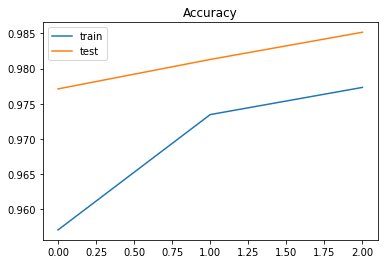

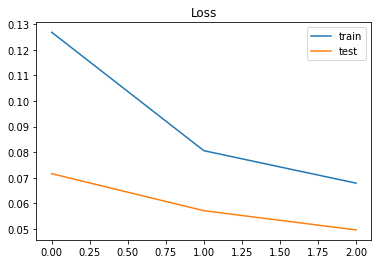

In [16]:
plot_history(history)

Quite overfitted. Training could stop after ~3 epochs and some regularizations (like dropout) could also make sense.  

**Node: Following output is from a build_model_rnn(...) run!**

Let's see if it is possible to further improve the model by unfreezing the embedding layer.

Also see https://www.tensorflow.org/guide/keras/transfer_learning

In [17]:
# Unfreeze all layers (i.e. make embeddings trainable)
model.trainable = True
model.summary()

Model: "rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 300)         61647900  
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                85248     
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_dropout (Dropout)      (None, 16)                0         
_________________________________________________________________
prediction (Dense)           (None, 1)                 17        
Total params: 61,734,205
Trainable params: 61,734,205
Non-trainable params: 0
___________________________________________________

In [18]:
re_compile_model(params, model)

In [19]:
params

{'verbose': True,
 'shuffle': True,
 'batch_size': 128,
 'X_column_name': 'text_clean',
 'y_column_name': 'label',
 'embedding_type': 'fasttext',
 'embedding_dim': 300,
 'embedding_mask_zero': True,
 'embedding_trainable': False,
 'embedding_fasttext_model': 'cc.de.300.bin',
 'embedding_word2vec_model_url': 'https://cloud.devmount.de/d2bc5672c523b086/german.model',
 'embedding_spacy_model': 'de_core_news_md',
 'embedding_tensorflow_hub_url': 'https://tfhub.dev/google/nnlm-de-dim128-with-normalization/2',
 'model_type': 'rnn',
 'classification_type': 'binary',
 'computed_objects': {'label_binarizer': LabelBinarizer(),
  'vocabulary': {'umarmt',
   'komplikationsbelastete',
   'erleichtet',
   'diabetesfall',
   'tobian',
   'lageänderungsschwindel',
   'vertrauendsvolle',
   'wanken',
   'fachartikeln',
   'bewegungsaufnahme',
   'erfoderliche',
   'bohrerbehandlung',
   'weiners',
   'sehenden',
   'meerower',
   'hüster',
   'tipp-ausführungen',
   'romer',
   'reinzusetzen',
   'rück

In [20]:
params["training_epochs"] = 2
history = train_model(params, model, dataset_train, dataset_val)

Epoch 1/2
3512/3512 [==============================] - 734s 208ms/step - loss: 0.0499 - accuracy: 0.9834 - val_loss: 0.0401 - val_accuracy: 0.9882
Epoch 2/2
3512/3512 [==============================] - 733s 209ms/step - loss: 0.0405 - accuracy: 0.9864 - val_loss: 0.0369 - val_accuracy: 0.9893


In [21]:
save_model(params, model, history)

INFO:tensorflow:Assets written to: models/rnn/20211008-155517/model_0.98935/assets


INFO:tensorflow:Assets written to: models/rnn/20211008-155517/model_0.98935/assets


In [22]:
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


In [23]:
from fhnw.nlp.utils.ploting import report_classification_results

Check performance on all data.

Set Population: 331187
Accuracy: 0.9845


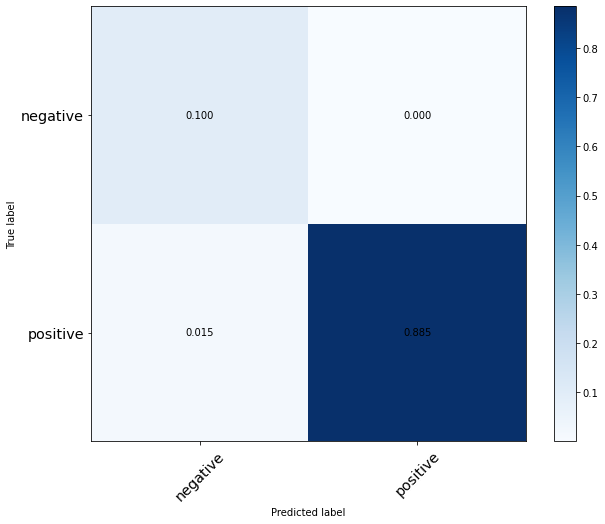

              precision    recall  f1-score   support

    negative       0.87      1.00      0.93     33022
    positive       1.00      0.98      0.99    298165

    accuracy                           0.98    331187
   macro avg       0.93      0.99      0.96    331187
weighted avg       0.99      0.98      0.99    331187

CPU times: user 41.6 s, sys: 981 ms, total: 42.6 s
Wall time: 34.3 s


In [24]:
%%time

report_classification_results(params, data, model)

Check performance on test data.

Set Population: 66238
Accuracy: 0.9806


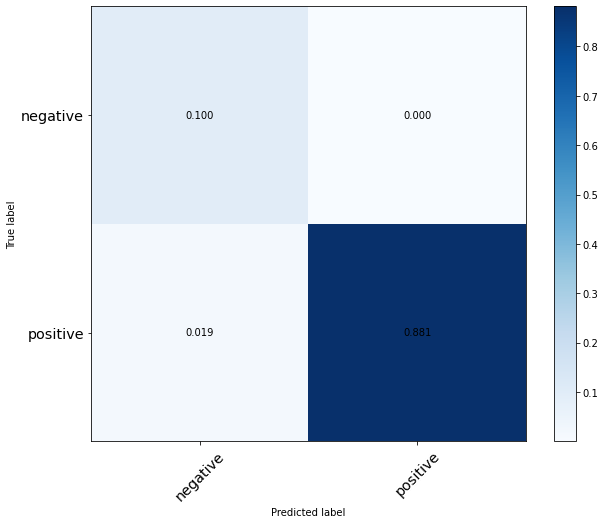

              precision    recall  f1-score   support

    negative       0.84      1.00      0.91      6604
    positive       1.00      0.98      0.99     59634

    accuracy                           0.98     66238
   macro avg       0.92      0.99      0.95     66238
weighted avg       0.98      0.98      0.98     66238

CPU times: user 7.5 s, sys: 241 ms, total: 7.74 s
Wall time: 6.43 s


In [25]:
%%time

report_classification_results(params, data_test, model)